In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover

In [3]:
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

In [4]:
def split_train_test(data, n_steps):
	X, y = [], []
	for i in range(n_steps, len(data)):
		X.append(data[i-n_steps:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

In [8]:
def compare_mse_model(model,model_1):
    mse_error = [model,model_1]
    error = pd.DataFrame({"Model" : ['model','model_1'], "MSE error": mse_error})
    return error

# n_splits = 5 and lags 5

## Run in loop

### unit 50

In [8]:
cv = TimeSeriesSplit(n_splits=5)
mse = []
for train,test in cv.split(cloud_cover):
    print('TRAIN:', train.shape, 'TEST:', test.shape) 
    train, test = cloud_cover.iloc[train, :], cloud_cover.iloc[test, :]
    train = train.set_index('DateTime')
    test = test.set_index('DateTime')
    sc = MinMaxScaler()
    sc = sc.fit(train)
    training_set_scaled = sc.transform(train)
    testing_set_scaled = sc.transform(test)

    # X_train, y_train
    X_train, y_train = split_train_test(training_set_scaled, 30)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # X_test, y_test
    dataset_total = pd.concat((train['cloud_cover'],test['cloud_cover']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(test) - 30:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test, y_test = split_train_test(inputs, 30)

    # model
    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 30, batch_size = 32) 
    predict_scaled = regressor.predict(X_test)
    predict = sc.inverse_transform(predict_scaled)
    test['LSTM'] = predict
    lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error)
    print('\n')
    mse.append(lstm_mse_error)

TRAIN: (2511,) TEST: (2510,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
78/78 [==============================] - 5s 30ms/step - loss: 0.0384 - val_loss: 0.0057
Epoch 2/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 4/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 5/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 6/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/30
78/78 [==============================] - 1s 17ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/30
78/78 [==============================] - 1s 19ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/30
78/78 [==============================] - 1s 18ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/30
78/78 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
156/156 [==============================] - 5s 19ms/step - loss: 0.0383 - val_loss: 0.0035
Epoch 2/30
156/156 [==============================] - 2s 14ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 3/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 4/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/30
156/156 [==============================] - 2s 14ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/30
156/156 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 7/30
156/156 [==============================] - 2s 14ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 9/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 10/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0019 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
235/235 [==============================] - 8s 20ms/step - loss: 0.0191 - val_loss: 0.0016
Epoch 2/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 3/30
235/235 [==============================] - 5s 19ms/step - loss: 0.0031 - val_loss: 8.9156e-04
Epoch 4/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0026 - val_loss: 6.7036e-04
Epoch 5/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0022 - val_loss: 5.9241e-04
Epoch 6/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0019 - val_loss: 4.6822e-04
Epoch 7/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0017 - val_loss: 5.4724e-04
Epoch 8/30
235/235 [==============================] - 3s 12ms/step - loss: 0.0015 - val_loss: 3.9649e-04
Epoch 9/30
235/235 [==============================] - 3s 13ms/step - loss: 0.0014 - val_loss: 3.1897e-04
Epoch 10/30
235/235 [==============================] - 3s 12ms/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
313/313 [==============================] - 7s 15ms/step - loss: 0.0146 - val_loss: 0.0052
Epoch 2/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 3/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 4/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 5/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0011 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/30
392/392 [==============================] - 7s 13ms/step - loss: 0.0087 - val_loss: 0.0034
Epoch 2/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 4/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 7/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/30
392/392 [==============================] - 5s 12ms/step - loss: 0.0011 - val_lo

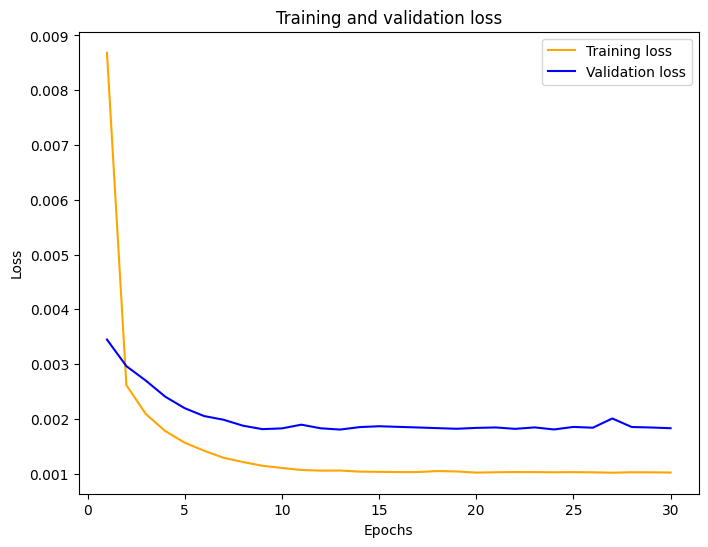

In [9]:
plot_curve(hist)

In [10]:
train.reset_index(inplace=True)

In [11]:
test.reset_index(inplace=True)

In [12]:
print('lstm_mse_error : ', lstm_mse_error)

lstm_mse_error :  0.0018213658406801708


In [13]:
plot_test(train,test)

In [14]:
for_unit_50 = np.mean(mse)
for_unit_50

0.0012123233279415003

### unit 100

In [18]:
cv1 = TimeSeriesSplit(n_splits=5)
mse_1 = []
for train1,test1 in cv1.split(cloud_cover):
    print('TRAIN:', train1.shape, 'TEST:', test1.shape) 
    train1, test1 = cloud_cover.iloc[train1, :], cloud_cover.iloc[test1, :]
    train1 = train1.set_index('DateTime')
    test1 = test1.set_index('DateTime')
    sc1 = MinMaxScaler()
    sc1 = sc1.fit(train1)
    training_set_scaled1 = sc1.transform(train1)
    testing_set_scaled1 = sc1.transform(test1)

    # X_train, y_train
    X_train1, y_train1 = split_train_test(training_set_scaled1, 30)
    X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))

    # X_test, y_test
    dataset_total1 = pd.concat((train1['cloud_cover'],test1['cloud_cover']), axis = 0)
    inputs1 = dataset_total1[len(dataset_total1) - len(test1) - 30:].values
    inputs1 = inputs1.reshape(-1,1)
    inputs1 = sc1.transform(inputs1)
    X_test1, y_test1 = split_train_test(inputs1, 30)

    # model
    regressor_1 = Sequential()
    regressor_1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
    regressor_1.add(Dense(units = 1))
    regressor_1.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_1 = regressor_1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 30, batch_size = 32)
    predict_scaled_1 = regressor_1.predict(X_test1)
    predict_1 = sc1.inverse_transform(predict_scaled_1)
    test1['LSTM'] = predict_1
    lstm_mse_error_unit_100 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error_unit_100)
    print('\n')
    mse_1.append(lstm_mse_error_unit_100)

TRAIN: (2511,) TEST: (2510,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
78/78 [==============================] - 7s 45ms/step - loss: 0.0286 - val_loss: 0.0052
Epoch 2/30
78/78 [==============================] - 2s 26ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 3/30
78/78 [==============================] - 2s 25ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 4/30
78/78 [==============================] - 2s 25ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/30
78/78 [==============================] - 2s 24ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 6/30
78/78 [==============================] - 2s 24ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/30
78/78 [==============================] - 2s 23ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/30
78/78 [==============================] - 2s 23ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/30
78/78 [==============================] - 2s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/30
78/78 [==============================] - 2s 23ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
156/156 [==============================] - 8s 28ms/step - loss: 0.0095 - val_loss: 0.0021
Epoch 2/30
156/156 [==============================] - 4s 24ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/30
156/156 [==============================] - 4s 23ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0020 - val_loss: 9.8531e-04
Epoch 7/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0019 - val_loss: 8.8870e-04
Epoch 8/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0017 - val_loss: 8.2740e-04
Epoch 9/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0016 - val_loss: 7.8266e-04
Epoch 10/30
156/156 [==============================] - 3s 22ms/step - loss:

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
235/235 [==============================] - 10s 28ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 2/30
235/235 [==============================] - 6s 26ms/step - loss: 0.0029 - val_loss: 8.6458e-04
Epoch 3/30
235/235 [==============================] - 6s 25ms/step - loss: 0.0024 - val_loss: 7.4532e-04
Epoch 4/30
235/235 [==============================] - 5s 22ms/step - loss: 0.0019 - val_loss: 6.9362e-04
Epoch 5/30
235/235 [==============================] - 6s 24ms/step - loss: 0.0017 - val_loss: 6.3165e-04
Epoch 6/30
235/235 [==============================] - 5s 22ms/step - loss: 0.0015 - val_loss: 3.8779e-04
Epoch 7/30
235/235 [==============================] - 5s 23ms/step - loss: 0.0014 - val_loss: 3.6906e-04
Epoch 8/30
235/235 [==============================] - 6s 25ms/step - loss: 0.0013 - val_loss: 3.1517e-04
Epoch 9/30
235/235 [==============================] - 5s 23ms/step - loss: 0.0012 - val_loss: 3.1446e-04
Epoch 10/30
235/235 [==============================] - 6s 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
313/313 [==============================] - 12s 26ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 2/30
313/313 [==============================] - 7s 22ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 3/30
313/313 [==============================] - 7s 22ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 4/30
313/313 [==============================] - 7s 22ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/30
313/313 [==============================] - 7s 21ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 6/30
313/313 [==============================] - 8s 25ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/30
313/313 [==============================] - 8s 25ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 8/30
313/313 [==============================] - 8s 24ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/30
313/313 [==============================] - 7s 21ms/step - loss: 9.5450e-04 - val_loss: 0.0017
Epoch 10/30
313/313 [==============================] - 7s 21ms/step - loss: 9.2468e-04

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
392/392 [==============================] - 12s 22ms/step - loss: 0.0085 - val_loss: 0.0035
Epoch 2/30
392/392 [==============================] - 11s 27ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 3/30
392/392 [==============================] - 9s 23ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/30
392/392 [==============================] - 10s 26ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/30
392/392 [==============================] - 9s 22ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/30
392/392 [==============================] - 8s 20ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 7/30
392/392 [==============================] - 8s 20ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/30
392/392 [==============================] - 8s 20ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/30
392/392 [==============================] - 9s 23ms/step - loss: 0.0011 - val

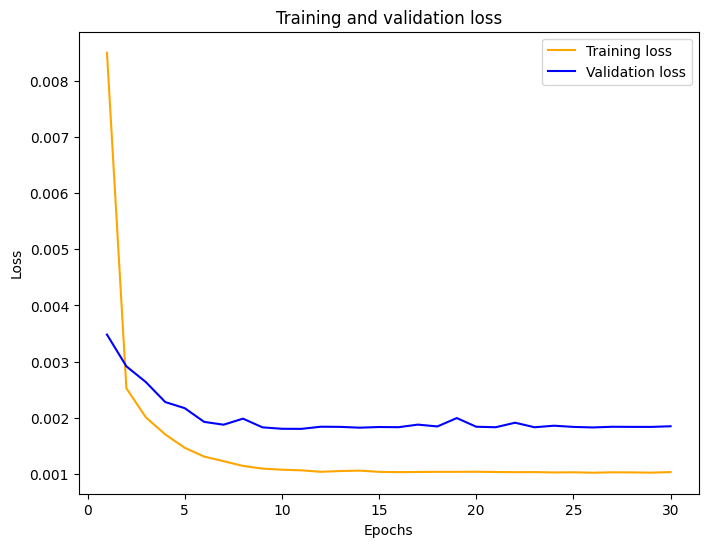

In [19]:
plot_curve(hist_1)

In [20]:
train1.reset_index(inplace=True)

In [21]:
test1.reset_index(inplace=True)

In [22]:
plot_test(train1, test1)

In [23]:
print('lstm_mse_error : ', lstm_mse_error_unit_100)

lstm_mse_error :  0.0018370994522157553


In [24]:
compare_mse_model(lstm_mse_error,lstm_mse_error_unit_100)

Model  MSE error
0    model   0.001821
1  model_1   0.001837

In [25]:
for_unit_100 = np.mean(mse_1)
for_unit_100

0.0012160870695195783

In [26]:
compare_mse_model(for_unit_50,for_unit_100)

Model  MSE error
0    model   0.001212
1  model_1   0.001216

### unit 50 and dropout 0.1

In [27]:
cv2 = TimeSeriesSplit(n_splits=5)
mse_2 = []
for train2,test2 in cv2.split(cloud_cover):
    print('TRAIN:', train2.shape, 'TEST:', test2.shape) 
    train2, test2 = cloud_cover.iloc[train2, :], cloud_cover.iloc[test2, :]
    train2 = train2.set_index('DateTime')
    test2 = test2.set_index('DateTime')
    sc2 = MinMaxScaler()
    sc2 = sc2.fit(train2)
    training_set_scaled2 = sc2.transform(train2)
    testing_set_scaled2 = sc2.transform(test2)

    # X_train, y_train
    X_train2, y_train2 = split_train_test(training_set_scaled2, 30)
    X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))

    # X_test, y_test
    dataset_total2 = pd.concat((train2['cloud_cover'],test2['cloud_cover']), axis = 0)
    inputs2 = dataset_total2[len(dataset_total2) - len(test2) - 30:].values
    inputs2 = inputs2.reshape(-1,1)
    inputs2 = sc2.transform(inputs2)
    X_test2, y_test2 = split_train_test(inputs2, 30)

    # model
    regressor_2 = Sequential()
    regressor_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train2.shape[1], 1)))
    regressor_2.add(Dropout(0.1))
    regressor_2.add(Dense(units = 1))
    regressor_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_2 = regressor_2.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 30, batch_size = 32)
    predict_scaled_2 = regressor_2.predict(X_test2)
    predict_2 = sc2.inverse_transform(predict_scaled_2)
    test2['LSTM'] = predict_2
    lstm_mse_error_unit_50_dropout = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error_unit_50_dropout)
    print('\n')
    mse_2.append(lstm_mse_error_unit_50_dropout)

TRAIN: (2511,) TEST: (2510,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
78/78 [==============================] - 7s 32ms/step - loss: 0.0342 - val_loss: 0.0057
Epoch 2/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 3/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 4/30
78/78 [==============================] - 2s 21ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 5/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 6/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/30
78/78 [==============================] - 2s 19ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 8/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 9/30
78/78 [==============================] - 2s 23ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 10/30
78/78 [==============================] - 2s 20ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
156/156 [==============================] - 8s 27ms/step - loss: 0.0143 - val_loss: 0.0022
Epoch 2/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 3/30
156/156 [==============================] - 2s 16ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 4/30
156/156 [==============================] - 2s 15ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 5/30
156/156 [==============================] - 2s 16ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 6/30
156/156 [==============================] - 2s 16ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 7/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 8/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/30
156/156 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 10/30
156/156 [==============================] - 3s 22ms/step - loss: 0.0029 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
235/235 [==============================] - 8s 18ms/step - loss: 0.0156 - val_loss: 0.0014
Epoch 2/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 3/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0042 - val_loss: 9.0384e-04
Epoch 4/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0036 - val_loss: 7.4800e-04
Epoch 5/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0034 - val_loss: 7.5324e-04
Epoch 6/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0031 - val_loss: 8.2404e-04
Epoch 7/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0030 - val_loss: 5.4005e-04
Epoch 8/30
235/235 [==============================] - 3s 14ms/step - loss: 0.0028 - val_loss: 6.3912e-04
Epoch 9/30
235/235 [==============================] - 3s 13ms/step - loss: 0.0026 - val_loss: 4.8690e-04
Epoch 10/30
235/235 [==============================] - 3s 13ms/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
313/313 [==============================] - 9s 17ms/step - loss: 0.0144 - val_loss: 0.0053
Epoch 2/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 4/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/30
313/313 [==============================] - 4s 13ms/step - loss: 0.0020 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
392/392 [==============================] - 16s 21ms/step - loss: 0.0107 - val_loss: 0.0034
Epoch 2/30
392/392 [==============================] - 9s 23ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/30
392/392 [==============================] - 8s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 4/30
392/392 [==============================] - 6s 16ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/30
392/392 [==============================] - 6s 15ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/30
392/392 [==============================] - 6s 14ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/30
392/392 [==============================] - 5s 14ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/30
392/392 [==============================] - 5s 13ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/30
392/392 [==============================] - 5s 13ms/step - loss: 0.0018 - val_l

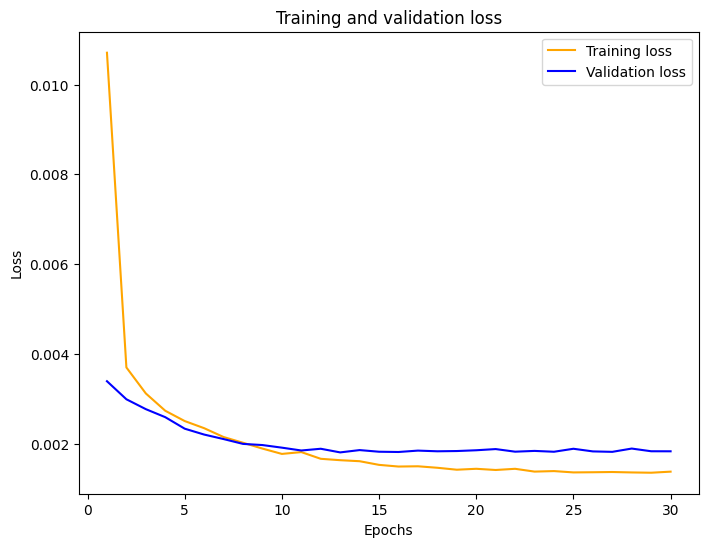

In [28]:
plot_curve(hist_2)

In [29]:
train2.reset_index(inplace=True)

In [30]:
test2.reset_index(inplace=True)

In [31]:
plot_test(train2, test2)

In [32]:
print('lstm_mse_error : ', lstm_mse_error_unit_50_dropout)

lstm_mse_error :  0.001821181650184376


In [33]:
compare_mse_model(lstm_mse_error,lstm_mse_error_unit_50_dropout)

Model  MSE error
0    model   0.001821
1  model_1   0.001821

In [34]:
for_unit_50_dropout = np.mean(mse_2)
for_unit_50_dropout

0.0012987179594756517

In [35]:
compare_mse_model(for_unit_50,for_unit_50_dropout)

Model  MSE error
0    model   0.001212
1  model_1   0.001299

### Add frist layer: units = 50 and change epochs from 30 to 50

In [37]:
cv3 = TimeSeriesSplit(n_splits=5)
mse_3 = []
for train3,test3 in cv3.split(cloud_cover):
    print('TRAIN:', train3.shape, 'TEST:', test3.shape) 
    train3, test3 = cloud_cover.iloc[train3, :], cloud_cover.iloc[test3, :]
    train3 = train3.set_index('DateTime')
    test3 = test3.set_index('DateTime')
    sc3 = MinMaxScaler()
    sc3 = sc3.fit(train3)
    training_set_scaled3 = sc3.transform(train3)
    testing_set_scaled3 = sc3.transform(test3)
    # X_train, y_train
    X_train3, y_train3 = split_train_test(training_set_scaled3, 30)
    X_train3 = np.reshape(X_train3, (X_train3.shape[0], X_train3.shape[1], 1))

    # X_test, y_test
    dataset_total3 = pd.concat((train3['cloud_cover'],test3['cloud_cover']), axis = 0)
    inputs3 = dataset_total3[len(dataset_total3) - len(test3) - 30:].values
    inputs3 = inputs3.reshape(-1,1)
    inputs3 = sc3.transform(inputs3)
    X_test3, y_test3 = split_train_test(inputs3, 30)

    # model
    regressor_3 = Sequential()
    regressor_3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
    regressor_3.add(Dense(units = 1))
    regressor_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_3 = regressor_3.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 50, batch_size = 32)
    predict_scaled_3 = regressor_3.predict(X_test3)
    predict_3 = sc3.inverse_transform(predict_scaled_3)
    test3['LSTM'] = predict_3
    lstm_mse_error_unit_50_epoch_50 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error_unit_50_epoch_50)
    print('\n')
    mse_3.append(lstm_mse_error_unit_50_epoch_50)

TRAIN: (2511,) TEST: (2510,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/50
78/78 [==============================] - 6s 29ms/step - loss: 0.0549 - val_loss: 0.0074
Epoch 2/50
78/78 [==============================] - 2s 20ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 3/50
78/78 [==============================] - 2s 20ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 4/50
78/78 [==============================] - 2s 20ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 5/50
78/78 [==============================] - 2s 21ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/50
78/78 [==============================] - 2s 20ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 7/50
78/78 [==============================] - 2s 22ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/50
78/78 [==============================] - 2s 22ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 9/50
78/78 [==============================] - 2s 20ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/50
78/78 [==============================] - 2s 21ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/50
156/156 [==============================] - 7s 24ms/step - loss: 0.0211 - val_loss: 0.0030
Epoch 2/50
156/156 [==============================] - 3s 17ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 3/50
156/156 [==============================] - 2s 16ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 4/50
156/156 [==============================] - 3s 17ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/50
156/156 [==============================] - 3s 17ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 6/50
156/156 [==============================] - 3s 18ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/50
156/156 [==============================] - 3s 17ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/50
156/156 [==============================] - 3s 16ms/step - loss: 0.0020 - val_loss: 9.5085e-04
Epoch 9/50
156/156 [==============================] - 3s 16ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 10/50
156/156 [==============================] - 2s 16ms/step - loss: 0.0017 - va

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/50
235/235 [==============================] - 8s 17ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0027 - val_loss: 7.9556e-04
Epoch 3/50
235/235 [==============================] - 3s 15ms/step - loss: 0.0023 - val_loss: 7.6108e-04
Epoch 4/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0020 - val_loss: 5.3180e-04
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0018 - val_loss: 4.6730e-04
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0016 - val_loss: 4.5798e-04
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0015 - val_loss: 3.6274e-04
Epoch 8/50
235/235 [==============================] - 3s 13ms/step - loss: 0.0013 - val_loss: 3.4225e-04
Epoch 9/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0013 - val_loss: 3.7542e-04
Epoch 10/50
235/235 [==============================] - 3s 1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/50
313/313 [==============================] - 9s 18ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 2/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 3/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 4/50
313/313 [==============================] - 5s 15ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 5/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 7/50
313/313 [==============================] - 5s 14ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/50
313/313 [==============================] - 4s 14ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 10/50
313/313 [==============================] - 5s 14ms/step - loss: 9.4623e-04 - va

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/50
392/392 [==============================] - 11s 18ms/step - loss: 0.0122 - val_loss: 0.0037
Epoch 2/50
392/392 [==============================] - 6s 16ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/50
392/392 [==============================] - 6s 16ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 4/50
392/392 [==============================] - 6s 15ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 5/50
392/392 [==============================] - 6s 15ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/50
392/392 [==============================] - 6s 16ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/50
392/392 [==============================] - 6s 15ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/50
392/392 [==============================] - 6s 15ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/50
392/392 [==============================] - 6s 16ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
392/392 [==============================] - 6s 16ms/step - loss: 0.0011 - val_l

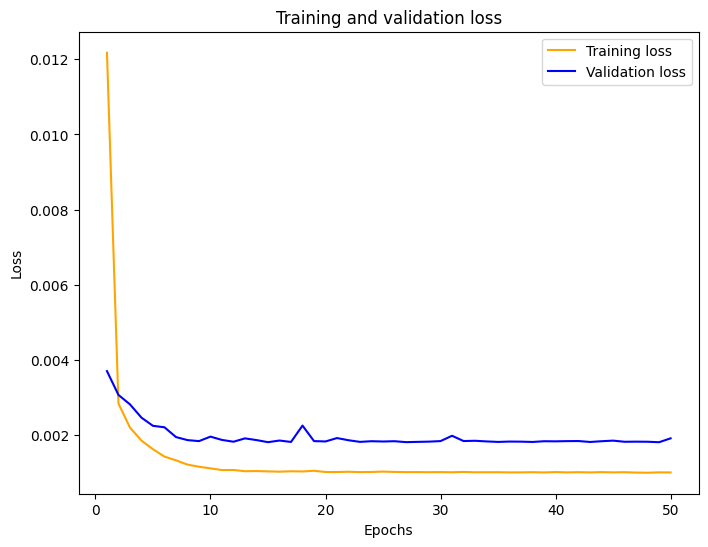

In [38]:
plot_curve(hist_3)

In [39]:
train3.reset_index(inplace=True)

In [40]:
test3.reset_index(inplace=True)

In [41]:
plot_test(train3, test3)

In [42]:
print('lstm_mse_error : ', lstm_mse_error_unit_50_epoch_50)

lstm_mse_error :  0.00191005796763446


In [43]:
compare_mse_model(lstm_mse_error,lstm_mse_error_unit_50_epoch_50)

Model  MSE error
0    model   0.001821
1  model_1   0.001910

In [44]:
for_unit_50_epoch_50 = np.mean(mse_3)
for_unit_50_epoch_50

0.0012379535285901677

In [45]:
compare_mse_model(for_unit_50,for_unit_50_epoch_50)

Model  MSE error
0    model   0.001212
1  model_1   0.001238

### Add frist layer: units = 50 and Add second layer: unit = 50

In [48]:
cv4 = TimeSeriesSplit(n_splits=5)
mse_4 = []
for train4,test4 in cv4.split(cloud_cover):
    print('TRAIN:', train4.shape, 'TEST:', test4.shape) 
    train4, test4 = cloud_cover.iloc[train4, :], cloud_cover.iloc[test4, :]
    train4 = train4.set_index('DateTime')
    test4 = test4.set_index('DateTime')
    sc4 = MinMaxScaler()
    sc4 = sc4.fit(train4)
    training_set_scaled4 = sc4.transform(train4)
    testing_set_scaled4 = sc4.transform(test4)
    # X_train, y_train
    X_train4, y_train4 = split_train_test(training_set_scaled4, 30)
    X_train4 = np.reshape(X_train4, (X_train4.shape[0], X_train4.shape[1], 1))

    # X_test, y_test
    dataset_total4 = pd.concat((train4['cloud_cover'],test4['cloud_cover']), axis = 0)
    inputs4 = dataset_total4[len(dataset_total4) - len(test4) - 30:].values
    inputs4 = inputs4.reshape(-1,1)
    inputs4 = sc4.transform(inputs4)
    X_test4, y_test4 = split_train_test(inputs4, 30)

    # model
    regressor_4 = Sequential()
    regressor_4.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train4.shape[1], 1)))
    regressor_4.add(LSTM(units = 50))
    regressor_4.add(Dense(units = 1))
    regressor_4.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_4 = regressor_4.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 30, batch_size = 32)
    predict_scaled_4 = regressor_4.predict(X_test4)
    predict_4 = sc4.inverse_transform(predict_scaled_4)
    test4['LSTM'] = predict_4
    lstm_mse_error_unit_50_second = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error_unit_50_second)
    print('\n')
    mse_4.append(lstm_mse_error_unit_50_second)

TRAIN: (2511,) TEST: (2510,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
78/78 [==============================] - 14s 74ms/step - loss: 0.0238 - val_loss: 0.0065
Epoch 2/30
78/78 [==============================] - 3s 41ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 3/30
78/78 [==============================] - 3s 42ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 4/30
78/78 [==============================] - 3s 39ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/30
78/78 [==============================] - 3s 42ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 6/30
78/78 [==============================] - 3s 40ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/30
78/78 [==============================] - 3s 41ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/30
78/78 [==============================] - 3s 38ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/30
78/78 [==============================] - 3s 40ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 10/30
78/78 [==============================] - 3s 39ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
156/156 [==============================] - 15s 42ms/step - loss: 0.0204 - val_loss: 0.0031
Epoch 2/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 3/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 4/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 6/30
156/156 [==============================] - 5s 31ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 7/30
156/156 [==============================] - 5s 29ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/30
156/156 [==============================] - 5s 31ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0019 - val_loss: 9.0732e-04
Epoch 10/30
156/156 [==============================] - 5s 30ms/step - loss: 0.0017 - v

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
235/235 [==============================] - 16s 36ms/step - loss: 0.0118 - val_loss: 0.0016
Epoch 2/30
235/235 [==============================] - 7s 29ms/step - loss: 0.0033 - val_loss: 9.2741e-04
Epoch 3/30
235/235 [==============================] - 7s 28ms/step - loss: 0.0025 - val_loss: 9.8447e-04
Epoch 4/30
235/235 [==============================] - 7s 29ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/30
235/235 [==============================] - 7s 29ms/step - loss: 0.0018 - val_loss: 4.7237e-04
Epoch 6/30
235/235 [==============================] - 7s 29ms/step - loss: 0.0016 - val_loss: 7.8092e-04
Epoch 7/30
235/235 [==============================] - 7s 28ms/step - loss: 0.0014 - val_loss: 4.6063e-04
Epoch 8/30
235/235 [==============================] - 7s 29ms/step - loss: 0.0014 - val_loss: 3.1261e-04
Epoch 9/30
235/235 [==============================] - 7s 28ms/step - loss: 0.0012 - val_loss: 6.1347e-04
Epoch 10/30
235/235 [==============================] - 7s 29ms

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
313/313 [==============================] - 19s 35ms/step - loss: 0.0119 - val_loss: 0.0059
Epoch 2/30
313/313 [==============================] - 9s 29ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 3/30
313/313 [==============================] - 9s 30ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 4/30
313/313 [==============================] - 9s 30ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/30
313/313 [==============================] - 9s 29ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/30
313/313 [==============================] - 9s 30ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 7/30
313/313 [==============================] - 9s 30ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/30
313/313 [==============================] - 10s 30ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 9/30
313/313 [==============================] - 10s 31ms/step - loss: 9.6923e-04 - val_loss: 0.0017
Epoch 10/30
313/313 [==============================] - 9s 29ms/step - loss: 9.3408e-

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
392/392 [==============================] - 20s 32ms/step - loss: 0.0118 - val_loss: 0.0037
Epoch 2/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 3/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 6/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/30
392/392 [==============================] - 11s 29ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 8/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/30
392/392 [==============================] - 11s 28ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 10/30
392/392 [==============================] - 11s 28ms/step - loss: 0.001

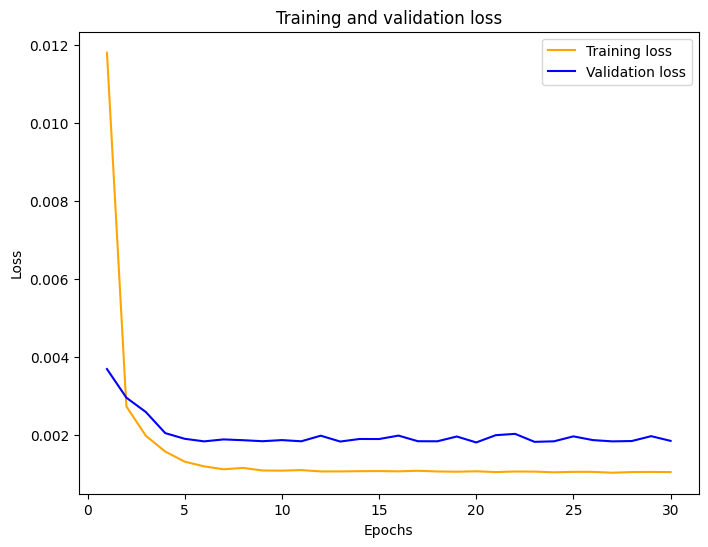

In [49]:
plot_curve(hist_4)

In [50]:
train4.reset_index(inplace=True)

In [51]:
test4.reset_index(inplace=True)

In [52]:
plot_test(train4, test4)

In [53]:
print('lstm_mse_error : ', lstm_mse_error_unit_50_second)

lstm_mse_error :  0.0018324610757395356


In [54]:
compare_mse_model(lstm_mse_error,lstm_mse_error_unit_50_second)

Model  MSE error
0    model   0.001821
1  model_1   0.001832

In [55]:
for_unit_50_second = np.mean(mse_4)
for_unit_50_second

0.0012691690777822185

In [56]:
compare_mse_model(for_unit_50,for_unit_50_second)

Model  MSE error
0    model   0.001212
1  model_1   0.001269

---

# n_spilt 3

## Add frist layer: units = 50

In [57]:
cv5 = TimeSeriesSplit(n_splits=3)
mse_5 = []
for train5,test5 in cv5.split(cloud_cover):
    print('TRAIN:', train5.shape, 'TEST:', test5.shape) 
    train5, test5 = cloud_cover.iloc[train5, :], cloud_cover.iloc[test5, :]
    train5 = train5.set_index('DateTime')
    test5 = test5.set_index('DateTime')
    sc5 = MinMaxScaler()
    sc5 = sc5.fit(train5)
    training_set_scaled5 = sc5.transform(train5)
    testing_set_scaled5 = sc5.transform(test5)

    # X_train, y_train
    X_train5, y_train5 = split_train_test(training_set_scaled5, 30)
    X_train5 = np.reshape(X_train5, (X_train5.shape[0], X_train5.shape[1], 1))

    # X_test, y_test
    dataset_total5 = pd.concat((train5['cloud_cover'],test5['cloud_cover']), axis = 0)
    inputs5 = dataset_total5[len(dataset_total5) - len(test5) - 30:].values
    inputs5 = inputs5.reshape(-1,1)
    inputs5 = sc5.transform(inputs5)
    X_test5, y_test5 = split_train_test(inputs5, 30)

    # model
    regressor_5 = Sequential()
    regressor_5.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train5.shape[1], 1)))
    regressor_5.add(Dense(units = 1))
    regressor_5.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_5 = regressor_5.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 30, batch_size = 32) 
    predict_scaled_5 = regressor_5.predict(X_test5)
    predict_5 = sc5.inverse_transform(predict_scaled_5)
    test5['LSTM'] = predict_5
    lstm_mse_error_spilt3 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
    print('lstm_mse_error : ', lstm_mse_error_spilt3)
    print('\n')
    mse_5.append(lstm_mse_error_spilt3)

TRAIN: (3766,) TEST: (3765,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
117/117 [==============================] - 11s 40ms/step - loss: 0.0168 - val_loss: 0.0026
Epoch 2/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 3/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 4/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/30
117/117 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 6/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/30
117/117 [==============================] - 2s 20ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 9/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/30
117/117 [==============================] - 2s 19ms/step - loss: 0.0021 - val_l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
235/235 [==============================] - 9s 23ms/step - loss: 0.0198 - val_loss: 0.0031
Epoch 2/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 3/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 4/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 5/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0016 - val_loss: 9.3013e-04
Epoch 9/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0015 - val_loss: 9.3954e-04
Epoch 10/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0014 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
353/353 [==============================] - 10s 18ms/step - loss: 0.0127 - val_loss: 0.0040
Epoch 2/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 3/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/30
353/353 [==============================] - 5s 16ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 7/30
353/353 [==============================] - 6s 16ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 8/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/30
353/353 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0011 - val_l

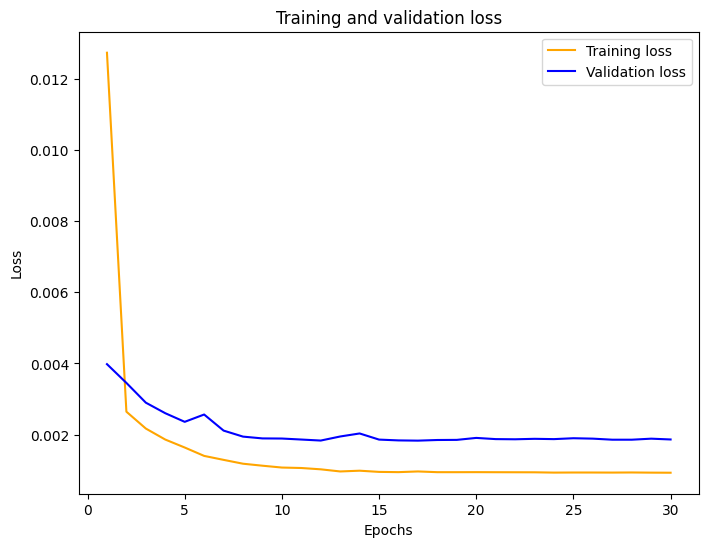

In [58]:
plot_curve(hist_5)

In [59]:
train5.reset_index(inplace=True)

In [60]:
test5.reset_index(inplace=True)

In [61]:
plot_test(train5,test5)

In [62]:
print('lstm_mse_error : ', lstm_mse_error_spilt3)

lstm_mse_error :  0.001852060103819419


In [63]:
compare_mse_model(lstm_mse_error,lstm_mse_error_spilt3)

Model  MSE error
0    model   0.001821
1  model_1   0.001852

In [64]:
for_unit_50_nspilt3 = np.mean(mse_5)
for_unit_50_nspilt3

0.0011578361785564636

In [65]:
compare_mse_model(for_unit_50,for_unit_50_nspilt3)

Model  MSE error
0    model   0.001212
1  model_1   0.001158

---

# n_spilt 7

## for in loop

In [66]:
cv6 = TimeSeriesSplit(n_splits=7)
mse_6 = []
for train6,test6 in cv6.split(cloud_cover):
    print('TRAIN:', train6.shape, 'TEST:', test6.shape) 
    train6, test6 = cloud_cover.iloc[train6, :], cloud_cover.iloc[test6, :]
    train6 = train6.set_index('DateTime')
    test6 = test6.set_index('DateTime')
    sc6 = MinMaxScaler()
    sc6 = sc6.fit(train6)
    training_set_scaled6 = sc6.transform(train6)
    testing_set_scaled6 = sc6.transform(test6)
    # X_train, y_train
    X_train6, y_train6 = split_train_test(training_set_scaled6, 30)
    X_train6 = np.reshape(X_train6, (X_train6.shape[0], X_train6.shape[1], 1))

    # X_test, y_test
    dataset_total6 = pd.concat((train6['cloud_cover'],test6['cloud_cover']), axis = 0)
    inputs6 = dataset_total6[len(dataset_total6) - len(test6) - 30:].values
    inputs6 = inputs6.reshape(-1,1)
    inputs6 = sc6.transform(inputs6)
    X_test6, y_test6 = split_train_test(inputs6, 30)

    # model
    regressor_6 = Sequential()
    regressor_6.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train6.shape[1], 1)))
    regressor_6.add(Dense(units = 1))
    regressor_6.compile(optimizer = 'adam', loss = 'mean_squared_error')
    hist_6 = regressor_6.fit(X_train6, y_train6, validation_data=(X_test6, y_test6), epochs = 30, batch_size = 32)
    predict_scaled_6 = regressor_6.predict(X_test6)
    predict_6 = sc6.inverse_transform(predict_scaled_6)
    test6['LSTM'] = predict_6
    lstm_mse_error_nsplit7_unit_50 = mean_squared_error(test6['cloud_cover'], test6['LSTM'], squared=True)      
    print('lstm_mse_error : ', lstm_mse_error_nsplit7_unit_50)
    print('\n') 
    mse_6.append(lstm_mse_error_nsplit7_unit_50)

TRAIN: (1887,) TEST: (1882,)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
59/59 [==============================] - 7s 49ms/step - loss: 0.0754 - val_loss: 0.0118
Epoch 2/30
59/59 [==============================] - 2s 26ms/step - loss: 0.0075 - val_loss: 0.0098
Epoch 3/30
59/59 [==============================] - 1s 24ms/step - loss: 0.0064 - val_loss: 0.0088
Epoch 4/30
59/59 [==============================] - 1s 25ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 5/30
59/59 [==============================] - 1s 23ms/step - loss: 0.0052 - val_loss: 0.0072
Epoch 6/30
59/59 [==============================] - 1s 22ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 7/30
59/59 [==============================] - 1s 22ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 8/30
59/59 [==============================] - 1s 22ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 9/30
59/59 [==============================] - 1s 22ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 10/30
59/59 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
117/117 [==============================] - 7s 28ms/step - loss: 0.0161 - val_loss: 0.0026
Epoch 2/30
117/117 [==============================] - 2s 18ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 3/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 4/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/30
117/117 [==============================] - 2s 18ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/30
117/117 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/30
117/117 [==============================] - 2s 17ms/step - loss: 0.0018 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
176/176 [==============================] - 8s 24ms/step - loss: 0.0142 - val_loss: 0.0027
Epoch 2/30
176/176 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 3/30
176/176 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 4/30
176/176 [==============================] - 3s 16ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/30
176/176 [==============================] - 3s 18ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/30
176/176 [==============================] - 4s 20ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 7/30
176/176 [==============================] - 4s 20ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/30
176/176 [==============================] - 3s 19ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/30
176/176 [==============================] - 3s 19ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/30
176/176 [==============================] - 3s 20ms/step - loss: 0.0018 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
235/235 [==============================] - 9s 20ms/step - loss: 0.0179 - val_loss: 0.0015
Epoch 2/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 3/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0028 - val_loss: 8.2488e-04
Epoch 4/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0024 - val_loss: 6.7596e-04
Epoch 5/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0019 - val_loss: 4.9840e-04
Epoch 7/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0017 - val_loss: 4.2182e-04
Epoch 8/30
235/235 [==============================] - 4s 15ms/step - loss: 0.0015 - val_loss: 3.9822e-04
Epoch 9/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0014 - val_loss: 3.9599e-04
Epoch 10/30
235/235 [==============================] - 4s 15ms/step

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
294/294 [==============================] - 9s 18ms/step - loss: 0.0100 - val_loss: 0.0033
Epoch 2/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 4/30
294/294 [==============================] - 5s 16ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/30
294/294 [==============================] - 5s 15ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/30
294/294 [==============================] - 4s 14ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/30
294/294 [==============================] - 4s 15ms/step - loss: 0.0010 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
353/353 [==============================] - 10s 17ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 2/30
353/353 [==============================] - 5s 14ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 3/30
353/353 [==============================] - 5s 14ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 4/30
353/353 [==============================] - 5s 13ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 5/30
353/353 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/30
353/353 [==============================] - 5s 14ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 7/30
353/353 [==============================] - 5s 13ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/30
353/353 [==============================] - 5s 14ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 9/30
353/353 [==============================] - 5s 14ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 10/30
353/353 [==============================] - 5s 15ms/step - loss: 0.0010 - val_l

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Epoch 1/30
411/411 [==============================] - 10s 15ms/step - loss: 0.0076 - val_loss: 0.0026
Epoch 2/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/30
411/411 [==============================] - 6s 14ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/30
411/411 [==============================] - 5s 13ms/step - loss: 0.0012 - val_l

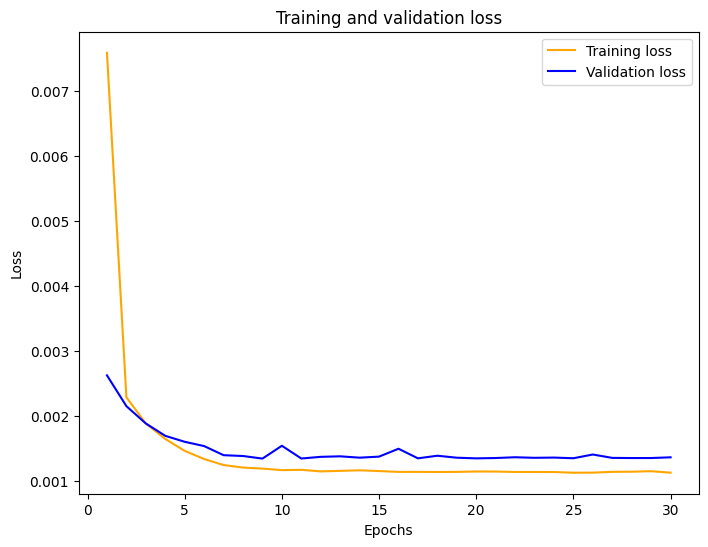

In [67]:
plot_curve(hist_6)

In [68]:
train6.reset_index(inplace=True)

In [69]:
test6.reset_index(inplace=True)

In [70]:
plot_test(train6, test6)

In [71]:
print('lstm_mse_error : ', lstm_mse_error_nsplit7_unit_50)

lstm_mse_error :  0.00135052863473169


In [72]:
compare_mse_model(lstm_mse_error,lstm_mse_error_nsplit7_unit_50)

Model  MSE error
0    model   0.001821
1  model_1   0.001351

In [73]:
for_unit_50_nspit7 = np.mean(mse_6)
for_unit_50_nspit7

0.00129301990943185

In [74]:
compare_mse_model(for_unit_50,for_unit_50_nspit7)

Model  MSE error
0    model   0.001212
1  model_1   0.001293

In [75]:
#regressor_6.save('lstm_test_cross_validation.h5')

In [76]:
# regressor.save('lstm_test_cross_validation_nsplit5.h5')